# MaxEnt-SMM Solver Benchmarks

Profiles the time spent in each phase of the solver to identify where time is going.

| Phase | What it measures |
|---|---|
| **Build / JIT compile** | `solver.build()` + first-iteration JAX tracing |
| **HMC advance** | `advance_buffer()` — leapfrog proposals across all chains |
| **Batch features** | `_batch_feature_fn()` — feature vector for every chain state |
| **Batch grad-θ** | `_batch_grad_theta_fn()` — ∂E/∂θ for every chain state |
| **Optax update** | Gradient assembly + Adam parameter update |

In [3]:
import sys, os
# Make sure the repo root is on the path when running from examples/
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath('.')), ''))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import jax

# Import benchmark module from the benchmarks/ directory
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath('.')), 'benchmarks'))
from benchmark_solver import (
    bench_build_time,
    bench_iteration_phases,
    bench_full_solve,
    sweep_n_vars,
    sweep_n_features,
    sweep_n_chains,
    _summarise_phases,
    run_benchmarks,
    print_results,
)

print(f'JAX backend : {jax.default_backend()}')
print(f'JAX devices : {jax.devices()}')

JAX backend : cpu
JAX devices : [CpuDevice(id=0)]


## 0. Configuration

Set `QUICK = True` for a fast pass (~1–2 min). Set to `False` for the full benchmark (~5–10 min).

In [4]:
QUICK = True          # flip to False for more thorough measurements
N_REPEATS = 5 if QUICK else 20

# Default problem size used for phase-breakdown and full-solve benchmarks
DEFAULT = dict(n_vars=3, n_features=10, n_chains=128)

# Sweep ranges
N_VARS_LIST     = [2, 3, 5]          if QUICK else [2, 3, 4, 5, 6, 8]
N_FEATURES_LIST = [4, 8, 16]         if QUICK else [4, 8, 12, 16, 24, 32]
N_CHAINS_LIST   = [32, 64, 128]      if QUICK else [32, 64, 128, 256]
N_ITER_FULL     = 30                 if QUICK else 100

## 1. Build & JIT Compile Time

`solver.build()` is pure Python (negligible). The first call to `solve()` triggers JAX to trace all computation graphs and compile XLA kernels—this is typically the largest one-time cost.

In [5]:
print('Measuring build + JIT compile time ...')
bt = bench_build_time(**DEFAULT)

print(f"\nbuild()          : {bt.build_sec * 1000:.1f} ms")
print(f"first iteration  : {bt.first_iter_sec * 1000:.1f} ms  (JAX trace + XLA compile)")

Measuring build + JIT compile time ...

build()          : 536.6 ms
first iteration  : 2820.7 ms  (JAX trace + XLA compile)


## 2. Per-Iteration Phase Breakdown

After warmup, each solver iteration consists of four sequential phases. We time them independently to find the bottleneck.

In [7]:
print(f'Measuring iteration phases (n_repeats={N_REPEATS}) ...')
phase_timings = bench_iteration_phases(**DEFAULT, n_repeats=N_REPEATS)
summary = _summarise_phases(phase_timings)

phases = ['hmc_sec', 'features_sec', 'grad_theta_sec', 'update_sec']
labels = ['HMC advance', 'Batch features', 'Batch grad-θ', 'Optax update']
total  = summary['total_sec']

print(f"\n{'Phase':<22}  {'Median (ms)':>12}  {'% of iter':>10}")
print('-' * 48)
for key, label in zip(phases, labels):
    val = summary[key]
    pct = 100 * val / total
    print(f"{label:<22}  {val*1000:>12.2f}  {pct:>9.1f}%")
print(f"{'Total':<22}  {total*1000:>12.2f}")

Measuring iteration phases (n_repeats=5) ...

Phase                    Median (ms)   % of iter
------------------------------------------------
HMC advance                     3.26       65.0%
Batch features                  0.13        2.5%
Batch grad-θ                    0.13        2.6%
Optax update                    1.41       28.2%
Total                           5.01


C:\Users\amdic\AppData\Local\Temp\ipykernel_34240\1308928833.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True,


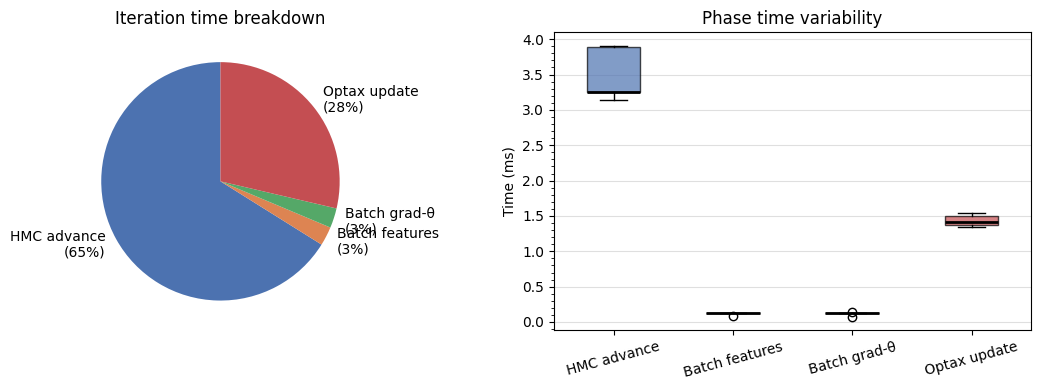

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# --- Left: pie chart of phase fractions ---
ax = axes[0]
values = [summary[k] for k in phases]
wedge_labels = [f'{l}\n({100*v/total:.0f}%)' for l, v in zip(labels, values)]
ax.pie(values, labels=wedge_labels, startangle=90,
       colors=['#4C72B0', '#DD8452', '#55A868', '#C44E52'])
ax.set_title('Iteration time breakdown')

# --- Right: box plots of phase times over all repeats ---
ax = axes[1]
data = [[getattr(t, k) * 1000 for t in phase_timings] for k in phases]
bp = ax.boxplot(data, labels=labels, patch_artist=True,
                medianprops=dict(color='black', linewidth=2))
colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel('Time (ms)')
ax.set_title('Phase time variability')
ax.tick_params(axis='x', labelrotation=15)
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax.grid(axis='y', alpha=0.4)

fig.tight_layout()
plt.show()

## 3. Full Solve: Per-Iteration Time History

Shows the JIT compile spike on the first iteration and steady-state throughput thereafter.

In [9]:
print(f'Running full solve ({N_ITER_FULL} iterations) ...')
fs = bench_full_solve(**DEFAULT, n_iterations=N_ITER_FULL)

print(f"\nTotal wall time      : {fs['total_sec']:.2f} s")
print(f"Iterations           : {fs['n_iterations']}")
print(f"Converged            : {fs['converged']}")
print(f"First iter (compile) : {fs['compile_iter_sec']*1000:.1f} ms")
if fs['steady_state_mean_sec']:
    print(f"Steady-state mean    : {fs['steady_state_mean_sec']*1000:.1f} ms")
    print(f"Steady-state median  : {fs['median_iter_sec']*1000:.1f} ms")

Running full solve (30 iterations) ...

Total wall time      : 1.79 s
Iterations           : 30
Converged            : False
First iter (compile) : 1601.3 ms
Steady-state mean    : 6.6 ms
Steady-state median  : 7.0 ms


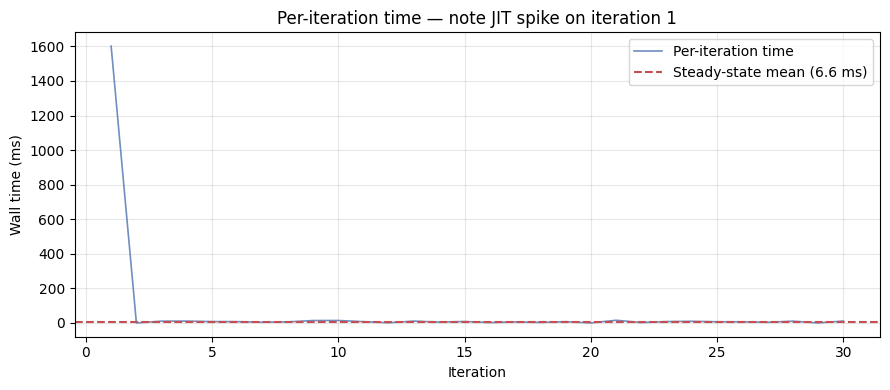

In [10]:
per_iter_ms = np.array(fs['per_iter_sec']) * 1000
iters = np.arange(1, len(per_iter_ms) + 1)

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(iters, per_iter_ms, lw=1.2, color='#4C72B0', alpha=0.8, label='Per-iteration time')
if len(per_iter_ms) > 1:
    ss_mean = fs['steady_state_mean_sec'] * 1000
    ax.axhline(ss_mean, color='#C44E52', ls='--', lw=1.5,
               label=f'Steady-state mean ({ss_mean:.1f} ms)')
ax.set_xlabel('Iteration')
ax.set_ylabel('Wall time (ms)')
ax.set_title('Per-iteration time — note JIT spike on iteration 1')
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

## 4. Scaling Sweeps

How does iteration time scale with each of the three main problem dimensions?

In [11]:
print('Sweeping n_vars ...')
sw_vars = sweep_n_vars(
    n_vars_list=N_VARS_LIST,
    n_features_base=DEFAULT['n_features'],
    n_chains=DEFAULT['n_chains'],
    n_repeats=N_REPEATS,
)

print('Sweeping n_features ...')
sw_feats = sweep_n_features(
    n_features_list=N_FEATURES_LIST,
    n_vars=DEFAULT['n_vars'],
    n_chains=DEFAULT['n_chains'],
    n_repeats=N_REPEATS,
)

print('Sweeping n_chains ...')
sw_chains = sweep_n_chains(
    n_chains_list=N_CHAINS_LIST,
    n_vars=DEFAULT['n_vars'],
    n_features=DEFAULT['n_features'],
    n_repeats=N_REPEATS,
)
print('Done.')

Sweeping n_vars ...
  n_vars=2, n_features=10 ...
  n_vars=3, n_features=10 ...
  n_vars=5, n_features=10 ...
Sweeping n_features ...
  n_features=4 ...
  n_features=8 ...
  n_features=16 ...
Sweeping n_chains ...
  n_chains=32 ...
  n_chains=64 ...
  n_chains=128 ...
Done.


In [ ]:
def _extract(sweep, x_key, *y_keys):
    x = [r[x_key] for r in sweep]
    ys = {k: np.array([r[k] * 1000 for r in sweep]) for k in y_keys}
    return x, ys

phase_keys  = ['hmc_sec', 'features_sec', 'grad_theta_sec', 'update_sec', 'total_sec']
phase_names = ['HMC', 'Features', 'Grad-θ', 'Update', 'Total']
colors      = ['#4C72B0', '#DD8452', '#55A868', '#C44E52', 'black']
styles      = ['-', '-', '-', '-', '--']
lws         = [1.5, 1.5, 1.5, 1.5, 2.2]

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

for ax, sweep, x_key, xlabel, title in [
    (axes[0], sw_vars,   'n_vars',     'Number of variables',       'Scaling: n_vars'),
    (axes[1], sw_feats,  'n_features', 'Number of features',        'Scaling: n_features'),
    (axes[2], sw_chains, 'n_chains',   'Number of parallel chains', 'Scaling: n_chains'),
]:
    x, ys = _extract(sweep, x_key, *phase_keys)
    for key, name, color, ls, lw in zip(phase_keys, phase_names, colors, styles, lws):
        ax.plot(x, ys[key], marker='o', ms=5, label=name, color=color, ls=ls, lw=lw)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Median iteration time (ms)')
    ax.set_title(title)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_xticks(x)

fig.tight_layout()
plt.show()

## 5. Stacked Phase Breakdown Across Sweeps

Shows how the fraction of time per phase changes as each parameter varies.

In [ ]:
stack_keys  = ['hmc_sec', 'features_sec', 'grad_theta_sec', 'update_sec']
stack_names = ['HMC', 'Features', 'Grad-θ', 'Update']
stack_colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52']

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, sweep, x_key, xlabel, title in [
    (axes[0], sw_vars,   'n_vars',     'n_vars',     'Phase split: n_vars'),
    (axes[1], sw_feats,  'n_features', 'n_features', 'Phase split: n_features'),
    (axes[2], sw_chains, 'n_chains',   'n_chains',   'Phase split: n_chains'),
]:
    x = [r[x_key] for r in sweep]
    # Compute fractions
    totals = np.array([r['total_sec'] for r in sweep])
    bottom = np.zeros(len(sweep))
    for key, name, color in zip(stack_keys, stack_names, stack_colors):
        vals = np.array([r[key] / t for r, t in zip(sweep, totals)]) * 100
        ax.bar(range(len(x)), vals, bottom=bottom, label=name, color=color, alpha=0.85)
        bottom += vals
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('% of iteration time')
    ax.set_title(title)
    ax.set_ylim(0, 100)
    ax.legend(fontsize=8, loc='lower right')

fig.tight_layout()
plt.show()

## 6. Summary Table

In [ ]:
def _print_sweep_table(sweep, x_key):
    cols = [x_key, 'total_sec', 'hmc_sec', 'features_sec', 'grad_theta_sec', 'update_sec']
    headers = [x_key, 'total (ms)', 'HMC (ms)', 'features (ms)', 'grad-θ (ms)', 'update (ms)']
    widths = [max(len(h), 10) for h in headers]
    header_row = '  '.join(h.rjust(w) for h, w in zip(headers, widths))
    print(header_row)
    print('-' * len(header_row))
    for row in sweep:
        vals = [row[x_key]] + [row[k] * 1000 for k in cols[1:]]
        fmts = [f'{vals[0]:>{widths[0]}}'] + [f'{v:>{widths[i+1]}.2f}' for i, v in enumerate(vals[1:])]
        print('  '.join(fmts))

print('=== n_vars sweep ===')
_print_sweep_table(sw_vars, 'n_vars')
print()
print('=== n_features sweep ===')
_print_sweep_table(sw_feats, 'n_features')
print()
print('=== n_chains sweep ===')
_print_sweep_table(sw_chains, 'n_chains')